<a href="https://colab.research.google.com/github/ILooeey/LSTM-Kel-12/blob/main/UAS_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [ ]:
# --- Download Data Saham ---
ticker = 'TLKM.JK'
data = yf.download(ticker, start='2010-01-01', end='2025-05-31')
if data.empty:
    raise ValueError("Data kosong, mungkin terjadi error saat download atau ticker tidak valid.")

<ipython-input-32-2353978699>:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2010-01-01', end='2025-05-31')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# --- Fitur yang digunakan: 'Close' dan 'Volume' ---
df = data[['Close', 'Volume']].copy()
df.dropna(inplace=True)

In [ ]:
# --- Pisahkan data training dan testing berdasarkan tanggal ---
train_df = df.loc[:'2020-03-31']
test_df = df.loc['2020-04-01':]

In [ ]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (2552, 2)
Testing data shape: (1239, 2)


In [ ]:
# --- Normalisasi ---
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.transform(test_df)

# --- Gabungkan 60 hari terakhir training dengan testing ---
last_60_train = scaled_train[-60:]
combined_scaled = np.concatenate((last_60_train, scaled_test), axis=0)

In [ ]:
# --- Fungsi Membuat Dataset Time-Series ---
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(scaled_train, time_step)
X_test, y_test = create_dataset(combined_scaled, time_step)

In [ ]:
# --- Model LSTM ---
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0425
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0035
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024
Epoch 14/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021
Epoch 15/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021
Epoch 16/50
78/

In [ ]:
# --- Prediksi ---
test_predict = model.predict(X_test)
test_predicted_prices = scaler.inverse_transform(np.hstack((test_predict, np.zeros((test_predict.shape[0], 1)))))[:, 0]

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
# --- Real Prices dan Dates untuk Jan - Mei ---
real_test_prices = test_df['Close'].values[time_step:]
real_test_dates = test_df.index[time_step:]
test_predicted_prices = test_predicted_prices[-len(real_test_prices):]

In [ ]:
# --- Hitung RMSE Jan - Mei 2025 ---
mse = mean_squared_error(real_test_prices, test_predicted_prices)
rmse = np.sqrt(mse)
print(f"MSE (Jan–Mei 2025): {mse:.4f}")
print(f"RMSE (Jan–Mei 2025): {rmse:.4f}")

MSE (Jan–Mei 2025): 5199.2467
RMSE (Jan–Mei 2025): 72.1058


In [ ]:
# --- Ambil 60 langkah terakhir dari data test untuk prediksi berantai ---
last_sequence = combined_scaled[-60:]
predicted_future = []

# --- Buat tanggal prediksi dari 1 Juni 2025 sampai 1 Januari 2028 (hari kerja) ---
future_dates = pd.bdate_range(start='2025-06-01', end='2026-06-30')
print(f"Jumlah hari kerja (prediksi): {len(future_dates)} hari")

Jumlah hari kerja (prediksi): 282 hari


In [ ]:
# --- Prediksi berantai ---
for _ in range(len(future_dates)):
    input_seq = last_sequence[-60:].reshape(1, 60, 2)
    pred = model.predict(input_seq, verbose=0)[0][0]
    predicted_future.append(pred)

    # Dummy volume tetap (gunakan volume terakhir)
    dummy_volume = last_sequence[-1, 1]
    last_sequence = np.vstack([last_sequence, [pred, dummy_volume]])

In [ ]:
# Gunakan volume terakhir asli saat inverse transform
future_scaled = np.array(predicted_future).reshape(-1, 1)
last_known_volume = df['Volume'].iloc[-1]
dummy_volume_arr = np.full_like(future_scaled, fill_value=last_known_volume)
future_combined = np.hstack((future_scaled, dummy_volume_arr))

predicted_future_prices = scaler.inverse_transform(future_combined)[:, 0]

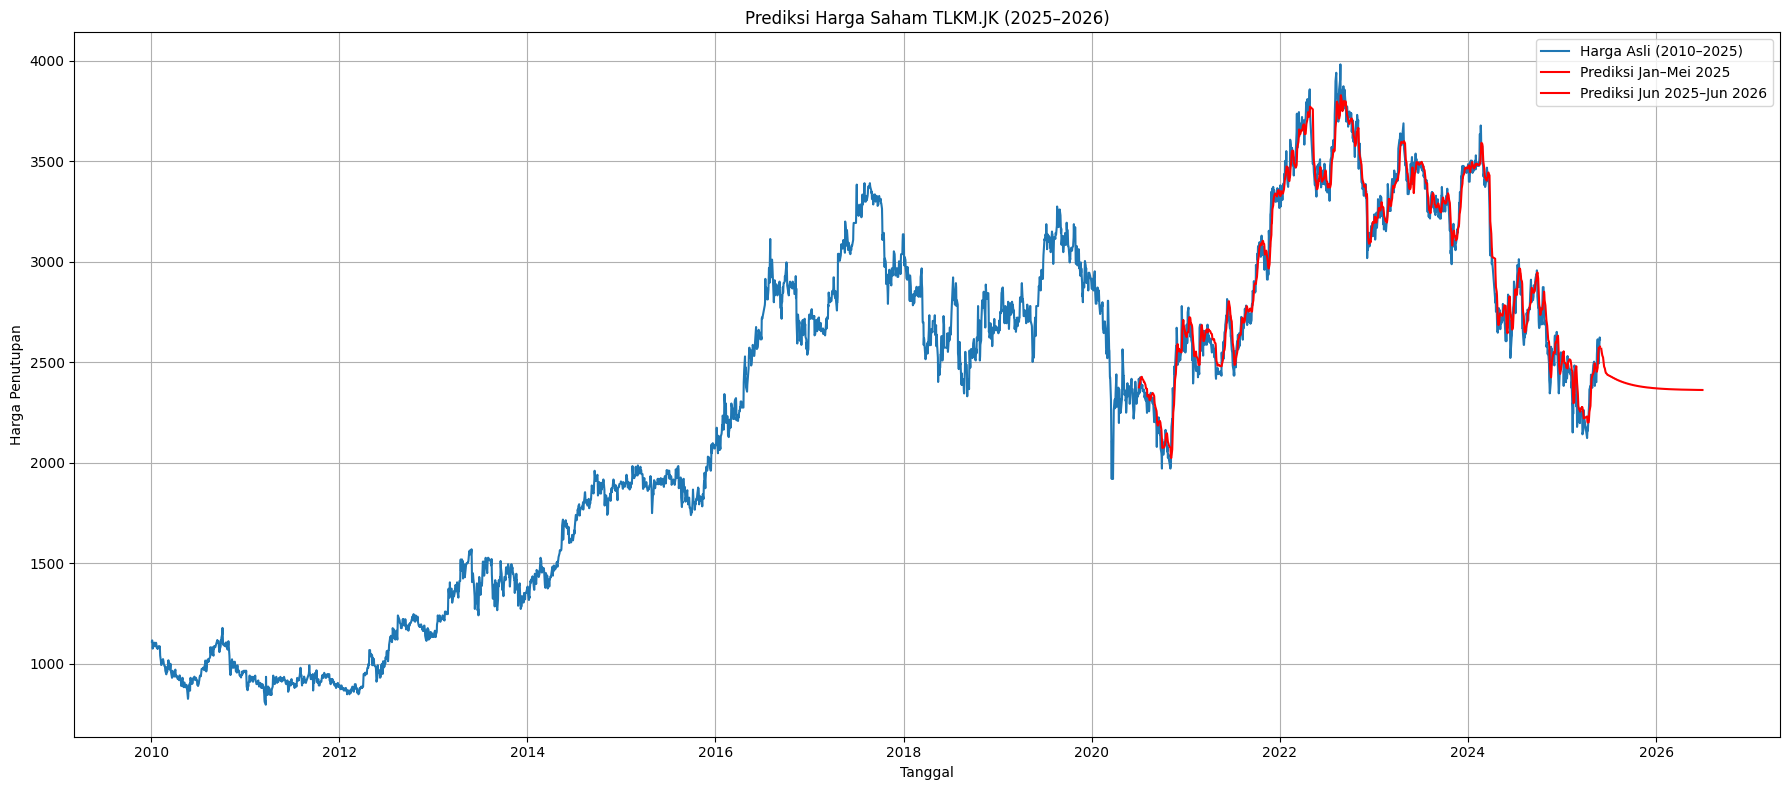

In [ ]:
# --- Gabungkan semua ke visualisasi ---
plt.figure(figsize=(18, 8))
plt.plot(df['Close'], label='Harga Asli (2010–2025)')
plt.plot(real_test_dates, test_predicted_prices, label='Prediksi Jan–Mei 2025', color='red')
plt.plot(future_dates, predicted_future_prices, label='Prediksi Jun 2025–Jun 2026', color='red')
plt.title('Prediksi Harga Saham TLKM.JK (2025–2026)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()